B4 einsum : torch.Size([1, 3, 2, 2, 128, 128])
Af einsum : torch.Size([1, 2, 2, 3, 128, 128])
torch.Size([3, 128, 128])


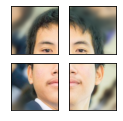

In [75]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch as th
from torch import nn
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
plt.rcParams["savefig.bbox"] = 'tight'
%matplotlib inline

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


transt = transforms.ToTensor()
transp = transforms.ToPILImage()
img_t = transt(Image.open('./moke.png'))

img_size = img_t.data.shape[1]
kernel_size = 128
n_patches = (img_size // kernel_size)

# patches = img_t.data.unfold(0, 3, 3).unfold(1, kernel_size, kernel_size).unfold(2, kernel_size, kernel_size)
patches = img_t.data.unfold(1, kernel_size, kernel_size).unfold(2, kernel_size, kernel_size)[None, ...]
print("B4 einsum :", patches.shape)
patches = torch.einsum('b c i j h w -> b i j c h w', patches)
print("Af einsum :", patches.shape)

print(patches[0][0][0].shape)

def visualize(n_patches, patches):
    """Imshow for Tensor."""    
    fig = plt.figure(figsize=(4, 4))
    for i in range(n_patches):
        for j in range(n_patches):
            inp = transp(patches[0][i][j])
            inp = np.array(inp)

            ax = fig.add_subplot(4, 4, ((i*4)+j)+1, xticks=[], yticks=[])
            plt.imshow(inp)

visualize(n_patches, patches)

64
torch.Size([1, 3, 256, 256])


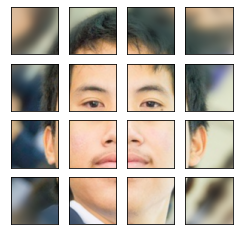

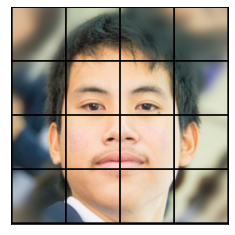

In [86]:
def normalization(channels, n_group=32):
    """
    Make a standard normalization layer.

    :param channels: number of input channels.
    :return: an nn.Module for normalization.
    """
    return GroupNorm(n_group, channels)

class GroupNorm(nn.GroupNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)

class AdaptiveGN_Hadamart(nn.Module):
    def __init__(self, prep, channels, n_patches):
        super().__init__()
        self.prep = prep
        self.channels = channels
        # self.patch_size = patch_size
        self.n_patches = n_patches
        self.layers = nn.ModuleList([
            normalization(channels),
        ])
        
    def forward(self, x, y):
        #TODO: Implement fw-pass
        #NOTE: Need to know the spatial resolution, Or probably specific the n_patch beforehand?
        assert x.shape == y.shape
        b, c, h, w = x.shape
        patch_size = h // self.n_patches
        print(patch_size)
        print(x.shape)
        patches = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        patches = torch.einsum('b c i j h w -> b i j c h w', patches)
        # print(patches.shape)
        visualize(n_patches=self.n_patches, patches=patches)
        b, i, j, c, h, w = patches.shape
        patches = patches.reshape(b, -1, c, h, w)
        grid = make_grid(patches[0], 4)
        show(grid)
        
# hadamart_layer = AdaptiveGN_Hadamart(prep='adaptive_gn', channels=32, patch_size=64)
hadamart_layer = AdaptiveGN_Hadamart(prep='adaptive_gn', channels=32, n_patches=4)
img_tensor = img_t.clone()[None, ...]
hadamart_layer(img_tensor, y=th.randn(img_tensor.shape))

In [58]:
d = torch.randn(10, 3, 105, 1024)
d = d.reshape(30, -1, -1)
d.shape

RuntimeError: only one dimension can be inferred